to do if there is time: 

- least similar song search for funsies

- create visualizations 

## Imports

In [0]:
!pip install spotipy
# https://spotipy.readthedocs.io/en/2.12.0/

In [0]:
!pip install spotify

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 1.2MB 8.0MB/s 
     |████████████████████████████████| 153kB 52.9MB/s 
     |████████████████████████████████| 256kB 44.9MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=d6978815ece8c1fc0f7a2beaf1e25b5fc5466e137f62c0e2e23109fc31de40d2
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [0]:
import pandas as pd
import numpy as np

import spotipy
from spotipy import oauth2, Spotify

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

## Spotify Authentication

In [0]:
# Spotify API authentication
cid ='555816fae63a45f29f50f99bbc81393d'
secret ='008dc4e8c3e3470c97392be068578540'

credentials = oauth2.SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=credentials)

## Track Info Functions

In [0]:
def fetch_info(artist_name, track_name):
  """
  function to retrieve relevant info on user's input from the Spotify API
  user inputs artist name and track name
  fxn gets info including the unique track id, album name, id, and cover image,
  a sample of the track if exists, and audio feature data for the track
  """
  data = sp.search(q=f'artist:{artist_name} track:{track_name}')
  artist_name = data['tracks']['items'][0]['artists'][0]['name']
  track_name = data['tracks']['items'][0]['name']
  track_id = data['tracks']['items'][0]['id']   
  album_name = data['tracks']['items'][0]['album']['name']
  album_id = data['tracks']['items'][0]['album']['id']
  album_cover_link = data['tracks']['items'][0]['album']['images'][0]['url']
  track_sample = data['tracks']['items'][0]['preview_url']
  audio_features = sp.audio_features(track_id)
  audio_features = audio_features[0] # changes the provided list from spotify into a dictionary
  irrelevant = ["id", "uri", "analysis_url", "type", "track_href"]
  for key in irrelevant:
    del audio_features[key]
  #audio_features = jsonify(audio_features) in FLASK app
  return track_name, artist_name, track_id, album_name, album_id, album_cover_link, track_sample, audio_features

In [0]:
fetch_info("Tame Impala", "Borderline")

('Borderline',
 'Tame Impala',
 '5hM5arv9KDbCHS0k9uqwjr',
 'The Slow Rush',
 '31qVWUdRrlb8thMvts0yYL',
 'https://i.scdn.co/image/ab67616d0000b27358267bd34420a00d5cf83a49',
 None,
 {'acousticness': 0.0406,
  'danceability': 0.621,
  'duration_ms': 237800,
  'energy': 0.873,
  'instrumentalness': 9.1e-06,
  'key': 5,
  'liveness': 0.0824,
  'loudness': -3.067,
  'mode': 0,
  'speechiness': 0.0369,
  'tempo': 97.96,
  'time_signature': 4,
  'valence': 0.873})

In [0]:
def track_feat(track_id):
  """
  function to retrieve relevant info from track ID and store it in a df
  """
  track_features = sp.audio_features(track_id)
  track_features = pd.DataFrame(track_features[0], index=[0])
  track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
  return track_features

In [0]:
track_feat('5hM5arv9KDbCHS0k9uqwjr')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.621,0.873,5,-3.067,0,0.0369,0.0406,0.000009,0.0824,0.873,97.96


## Database


In [0]:
# 5/27 created new dataset with top tracks from the past two years

tracks = pd.read_csv("https://raw.githubusercontent.com/Build-Week-Spotify-Song-Suggester-2/datascience/master/SpotifyTrackFeatures.csv", error_bad_lines=False)
print(tracks.shape)
tracks.head()

(120104, 17)


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373.0,0.339,0.000,1,0.0812,-7.678,1.0,0.4090,203.927,4.0,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800.0,0.557,0.000,8,0.2860,-7.259,1.0,0.4570,159.009,4.0,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913.0,0.723,0.000,9,0.0824,-5.890,0.0,0.0454,114.966,4.0,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381.0,0.579,0.912,5,0.0994,-12.118,0.0,0.0701,123.003,4.0,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016.0,0.792,0.878,7,0.0332,-10.277,1.0,0.0661,120.047,4.0,0.928,8


In [0]:
tracks = pd.DataFrame(tracks)
tracks.dtypes

artist_name          object
track_id             object
track_name           object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
popularity            int64
dtype: object

In [0]:
tracks = tracks.drop_duplicates(['track_id'])
tracks.shape

(119923, 17)

## KNN

section for creating and tweaking KNN model

In [0]:
# scale data and create model

mdf = tracks # dataset
# track_id = '5hM5arv9KDbCHS0k9uqwjr'
target   = ['track_id']
features = ['danceability',
            'energy',
            'key', 
            'loudness',
            'mode',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'tempo'] # duration, popularity, and time are not good predictors of similarity 

# features = features.danceability.str.strip(" ","")
X = mdf[features] # .astype('float64')
y = mdf[target]

# Scale the features to a mean of 0 and a standard deviation of 1.
#scaler = StandardScaler()
# X = scaler.fit_transform(X)

nn = NearestNeighbors(n_neighbors=11, algorithm='kd_tree').fit(X, y) # 11 for top 10 similarities 

In [0]:
def testmodel(track_id, ouput = mdf):
  """
  function for testing KNN
  """
  mdf = tracks
  # target   = ['track_id']
  features = ['danceability',
                'energy',
                'key', 
                'loudness',
                'mode',
                'speechiness',
                'acousticness',
                'instrumentalness',
                'liveness',
                'valence',
                'tempo']
  # get track audio features from track id and put into a df
  track_features = sp.audio_features(track_id)
  track_features = pd.DataFrame(track_features[0], index=[0])
  track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
  # apply model to get prediciton
  pred = nn.kneighbors(track_features)

  return pred

In [0]:
track_features = sp.audio_features('0SUClY63fA1awioMFtMYeE')
track_features = pd.DataFrame(track_features[0], index=[0])

In [0]:
track_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.39,0.965,0,-3.38,0,0.119,0.0181,0,0.583,0.195,168.006,audio_features,0SUClY63fA1awioMFtMYeE,spotify:track:0SUClY63fA1awioMFtMYeE,https://api.spotify.com/v1/tracks/0SUClY63fA1a...,https://api.spotify.com/v1/audio-analysis/0SUC...,181307,4


In [0]:
testmodel('0SUClY63fA1awioMFtMYeE', mdf)
# run model on two tracks to make sure it is actually working/returning different data

(array([[1.15523602, 1.17359574, 1.24663309, 1.46918809, 1.55907674,
         1.58694956, 1.59215164, 1.60927302, 1.62633552, 1.63009134,
         1.63064454]]),
 array([[109214,  33254,  15463, 109351,  39696,  49677,  78022,   8970,
          16332,  25845, 112343]]))

In [0]:
testmodel('5hM5arv9KDbCHS0k9uqwjr', mdf)
# cool it works, lets try and change the output into something a human will understand

(array([[0.43042175, 0.58710596, 0.71969769, 0.77602114, 0.96806633,
         1.05083391, 1.1720763 , 1.17825141, 1.18084383, 1.22232363,
         1.24163994]]),
 array([[  4367,  18947,   5292, 112778,  41403,  48790,  53738,  88818,
         108717,  75692, 103851]]))

In [0]:
def predict(track_id, ouput = mdf):
    """
    track recommender function
    takes track_id input and ouputs a list of 10 similar tracks with artist name
    """
    mdf = tracks
    features = ['danceability',
                'energy',
                'key', 
                'loudness',
                'mode',
                'speechiness',
                'acousticness',
                'instrumentalness',
                'liveness',
                'valence',
                'tempo']

    # get track audio features via track id and put into a df
    track_features = sp.audio_features(track_id)
    track_features = pd.DataFrame(track_features[0], index=[0])
    #track_features = track_features.astype(({'track_id': 'int32'}))
    track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
    pred = nn.kneighbors(track_features)

    return_rec = {}
    for index,i in enumerate(pred[1][0]):
      return_rec[str(index)] = {"track_name" : tracks['track_name'].iloc[i],
                                   "artist" : tracks['artist_name'].iloc[i]}
    # probably have to jsonify this in FLASK
  
    return return_rec

In [0]:
track_features = sp.audio_features('5hM5arv9KDbCHS0k9uqwjr')
track_features = pd.DataFrame(track_features[0], index=[0])
#track_features = track_features.astype(({'track_id': 'int32'}))
track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
pred = nn.kneighbors(track_features)

In [0]:
pred

(array([[0.43042175, 0.58710596, 0.71969769, 0.77602114, 0.96806633,
         1.05083391, 1.1720763 , 1.17825141, 1.18084383, 1.22232363,
         1.24163994]]),
 array([[  4367,  18947,   5292, 112778,  41403,  48790,  53738,  88818,
         108717,  75692, 103851]]))

In [0]:
return_rec = {}
for index,i in enumerate(pred[1][0]):
    return_rec[str(index)] = {"track_name" : tracks['track_name'].iloc[i],
                                   "artist" : tracks['artist_name'].iloc[i]}
    # probabrely have to jsonify this in FLASK

In [0]:
return_rec

{'0': {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 '1': {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 '10': {'artist': 'Stray Kids', 'track_name': 'Question'},
 '2': {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 '3': {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'},
 '4': {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 '5': {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 '6': {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 '7': {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 '8': {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 '9': {'artist': 'Dikla', 'track_name': 'אתי'}}

In [0]:
return_rec = {}
arr = pred[1][0]
for index,i in enumerate(arr):
    return_rec[str(index)] = {"track_name" : tracks['track_name'].iloc[i],
                                   "artist" : tracks['artist_name'].iloc[i]}
return_rec

{'0': {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 '1': {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 '10': {'artist': 'Stray Kids', 'track_name': 'Question'},
 '2': {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 '3': {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'},
 '4': {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 '5': {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 '6': {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 '7': {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 '8': {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 '9': {'artist': 'Dikla', 'track_name': 'אתי'}}

In [0]:
return_rec = {}
for i in arr:
    return_rec[i] = {"track_name" : tracks['track_name'].iloc[i],
                                   "artist" : tracks['artist_name'].iloc[i]}
return_rec

{4367: {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 5292: {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 18947: {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 41403: {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 48790: {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 53738: {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 75692: {'artist': 'Dikla', 'track_name': 'אתי'},
 88818: {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 103851: {'artist': 'Stray Kids', 'track_name': 'Question'},
 108717: {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 112778: {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'}}

In [0]:
return_rec

{4367: {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 5292: {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 18947: {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 41403: {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 48790: {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 53738: {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 75692: {'artist': 'Dikla', 'track_name': 'אתי'},
 88818: {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 103851: {'artist': 'Stray Kids', 'track_name': 'Question'},
 108717: {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 112778: {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'}}

In [0]:
predict('0SUClY63fA1awioMFtMYeE', mdf)
# so model works but readable output function isnt working as intended

{'0': {'artist': 'Sam Fender', 'track_name': 'Dead Boys'},
 '1': {'artist': 'Mr. Knightowl', 'track_name': 'The Way You Make Me Feel'},
 '10': {'artist': 'Passion', 'track_name': 'Reckless Love - Live'},
 '2': {'artist': 'Geru y Su Legion 7', 'track_name': 'Mujer De Piedra'},
 '3': {'artist': 'Jayne Denham', 'track_name': 'Hung up on You'},
 '4': {'artist': 'Imagine Dragons', 'track_name': 'Thunder'},
 '5': {'artist': 'Grupo Vanguardia', 'track_name': 'Mala Vida No Me Doy'},
 '6': {'artist': 'The Trews',
  'track_name': 'Mistress Misery - No Time for Later Outtake'},
 '7': {'artist': 'Two Door Cinema Club',
  'track_name': 'Cigarettes In The Theatre - Original Demo'},
 '8': {'artist': 'Elephant Man', 'track_name': 'Rude Bwoy Skank'},
 '9': {'artist': 'Moophs', 'track_name': 'OMW (feat. Inigo Pascual)'}}

In [0]:
predict('5hM5arv9KDbCHS0k9uqwjr', mdf)
# seems to be returning just a list of tracks from the dataset instead of the actual model output(?)

{'0': {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 '1': {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 '10': {'artist': 'Stray Kids', 'track_name': 'Question'},
 '2': {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 '3': {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'},
 '4': {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 '5': {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 '6': {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 '7': {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 '8': {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 '9': {'artist': 'Dikla', 'track_name': 'אתי'}}

In [0]:
list_of_predictions = pred[1][0].tolist()
list_of_predictions

[4367, 18947, 5292, 112778, 41403, 48790, 53738, 88818, 108717, 75692, 103851]

In [0]:
def predict(track_id, ouput = mdf):
    """
    track recommender function
    takes track_id input and ouputs a list of 10 similar tracks with artist name
    """
    mdf = tracks
    features = ['danceability',
                'energy',
                'key', 
                'loudness',
                'mode',
                'speechiness',
                'acousticness',
                'instrumentalness',
                'liveness',
                'valence',
                'tempo']

    # get track audio features via track id and put into a df
    track_features = sp.audio_features(track_id)
    track_features = pd.DataFrame(track_features[0], index=[0])
    #track_features = track_features.astype(({'track_id': 'int32'}))
    track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
    pred = nn.kneighbors(track_features)

    return_rec = {}
    arr = pred[1][0]
    for i in arr:
        return_rec[i] = {"track_name" : tracks['track_name'].iloc[i],
                          "artist" : tracks['artist_name'].iloc[i]}
    # probably have to jsonify this in FLASK
    return return_rec

### add scaling  IGNORE


In [0]:
def Spredict(track_id, ouput = mdf):
    """
    track recommender function
    takes track_id input and ouputs a list of 10 similar tracks with artist name
    """
    scaler = StandardScaler()
    mdf = tracks
    features = ['danceability',
                'energy',
                'key', 
                'loudness',
                'mode',
                'speechiness',
                'acousticness',
                'instrumentalness',
                'liveness',
                'valence',
                'tempo']
    # get track audio features via track id and put into a df
    track_features = sp.audio_features(track_id)
    track_features = pd.DataFrame(track_features[0], index=[0])
    #track_features = track_features.astype(({'track_id': 'int32'}))
    track_features = track_features.drop(columns=["id", "uri", "analysis_url", "type", "track_href", "duration_ms", "time_signature"])
    
    scaled_feat = scaler.fit_transform(track_features)
    pred = nn.kneighbors(scaled_feat)

    return_rec = {}
    for index,i in enumerate(pred[1][0]):
      return_rec[str(index)] = {"track_name" : tracks['track_name'].iloc[i],
                                   "artist" : tracks['artist_name'].iloc[i]}
    # probably have to jsonify this in FLASK
  
    return return_rec

In [0]:
# test scaling
# input song not scaled
# Tame Impala Borderline
predict('5hM5arv9KDbCHS0k9uqwjr', mdf)

{'0': {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 '1': {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 '10': {'artist': 'Stray Kids', 'track_name': 'Question'},
 '2': {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 '3': {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'},
 '4': {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 '5': {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 '6': {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 '7': {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 '8': {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 '9': {'artist': 'Dikla', 'track_name': 'אתי'}}

In [0]:
# input song scaled 
Spredict('5hM5arv9KDbCHS0k9uqwjr', mdf)

{'0': {'artist': 'letherette', 'track_name': 'In Love'},
 '1': {'artist': 'Daniel Miller', 'track_name': 'Drink Da Shot'},
 '10': {'artist': 'White Noise Sleep Sounds', 'track_name': 'Fall Rise Fall'},
 '2': {'artist': 'White Noise Babies', 'track_name': 'TV Tuned Out'},
 '3': {'artist': 'frumhere', 'track_name': 'lan rover'},
 '4': {'artist': 'BluntOne', 'track_name': 'Akasha'},
 '5': {'artist': 'Neighborhood Crook', 'track_name': 'Forgien Wit Mans'},
 '6': {'artist': 'White Noise Baby Sleep',
  'track_name': 'Frequency Filtered White'},
 '7': {'artist': 'Sleep Noise Relax',
  'track_name': 'High Hairdryer Looped (Loopable Hair Dryer Sounds)'},
 '8': {'artist': 'Qawi Kamri', 'track_name': 'Make You Proud'},
 '9': {'artist': 'Waka Flocka Flame',
  'track_name': 'Tune-Up Man Skit (feat. Slim Dunkin)'}}

In [0]:
# britney spears toxic
# no scaling
predict('4fbaKWFRghusXd4bSBvvfN', mdf)

{'0': {'artist': 'Britney Spears', 'track_name': 'Toxic'},
 '1': {'artist': 'MC Lyte', 'track_name': 'Get It Started'},
 '10': {'artist': 'Bazzi', 'track_name': 'Fantasy'},
 '2': {'artist': 'Reaper Funk', 'track_name': 'Reaper'},
 '3': {'artist': 'DON BROCO', 'track_name': 'Tightrope'},
 '4': {'artist': '초록픽하나', 'track_name': '내꺼'},
 '5': {'artist': 'Our Last Night', 'track_name': 'Fantasy Land'},
 '6': {'artist': 'Suave', 'track_name': 'Leave'},
 '7': {'artist': 'Zulma Lockyer', 'track_name': 'Nice Justice'},
 '8': {'artist': 'XXXTENTACION', 'track_name': 'BAD!'},
 '9': {'artist': 'LEE KANG', 'track_name': 'In Vain (feat. Yang Da Il)'}}

In [0]:
# input song scaled
Spredict('4fbaKWFRghusXd4bSBvvfN', mdf)

{'0': {'artist': 'letherette', 'track_name': 'In Love'},
 '1': {'artist': 'Daniel Miller', 'track_name': 'Drink Da Shot'},
 '10': {'artist': 'White Noise Sleep Sounds', 'track_name': 'Fall Rise Fall'},
 '2': {'artist': 'White Noise Babies', 'track_name': 'TV Tuned Out'},
 '3': {'artist': 'frumhere', 'track_name': 'lan rover'},
 '4': {'artist': 'BluntOne', 'track_name': 'Akasha'},
 '5': {'artist': 'Neighborhood Crook', 'track_name': 'Forgien Wit Mans'},
 '6': {'artist': 'White Noise Baby Sleep',
  'track_name': 'Frequency Filtered White'},
 '7': {'artist': 'Sleep Noise Relax',
  'track_name': 'High Hairdryer Looped (Loopable Hair Dryer Sounds)'},
 '8': {'artist': 'Qawi Kamri', 'track_name': 'Make You Proud'},
 '9': {'artist': 'Waka Flocka Flame',
  'track_name': 'Tune-Up Man Skit (feat. Slim Dunkin)'}}

## KNN v2
created to help compare our KNN vs NN models
scaled , using slightly different input system
got incredibly similar results to first KNN

In [0]:
# test scaling and remake model

In [0]:
modeldf = tracks.copy()
modeldf["track_index"] = modeldf.index +1
dictionary = modeldf[["artist_name", "track_name", "track_id", "track_index"]]
modeldf.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,track_index
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373.0,0.339,0.000,1.0,0.0812,-7.678,1.0,0.4090,203.927,4.0,0.118,44,1
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800.0,0.557,0.000,8.0,0.2860,-7.259,1.0,0.4570,159.009,4.0,0.371,10,2
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913.0,0.723,0.000,9.0,0.0824,-5.890,0.0,0.0454,114.966,4.0,0.382,63,3
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381.0,0.579,0.912,5.0,0.0994,-12.118,0.0,0.0701,123.003,4.0,0.641,9,4
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016.0,0.792,0.878,7.0,0.0332,-10.277,1.0,0.0661,120.047,4.0,0.928,8,5


In [0]:
modeldf = modeldf.drop(columns=['artist_name','track_id', 'track_name','duration_ms', 'mode', 'time_signature'])
modeldf.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,popularity,track_index
0,0.005820,0.743,0.339,0.000,1.0,0.0812,-7.678,0.4090,203.927,0.118,44,1
1,0.024400,0.846,0.557,0.000,8.0,0.2860,-7.259,0.4570,159.009,0.371,10,2
2,0.025000,0.603,0.723,0.000,9.0,0.0824,-5.890,0.0454,114.966,0.382,63,3
3,0.029400,0.800,0.579,0.912,5.0,0.0994,-12.118,0.0701,123.003,0.641,9,4
4,0.000035,0.783,0.792,0.878,7.0,0.0332,-10.277,0.0661,120.047,0.928,8,5


In [0]:
def predictv2(track_index, ouput = mdf):
    """
    track recommender function
    takes track_id input and ouputs a list of 10 similar tracks with artist name
    """
    #scale
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(modeldf)

    # input track index to actual track index
    input_dict = dictionary[dictionary['track_index']==track_index]
    given_index = input_dict.index

    # KNN model, 11 for top 10
    nn = NearestNeighbors(n_neighbors=11, algorithm='kd_tree')
    nn.fit(df_scaled)
    pred = nn.kneighbors(df_scaled[given_index])

    # create list of recommended track indexes
    pred_list = pred[1][0].tolist()

    # output top 10 recommended tracks
    top10 = []
    for item in pred_list:
      rec_track = dictionary['track_id'].iloc[item]
      top10.append(rec_track)
    return return_rec

In [0]:
print(dictionary[dictionary['track_id']=='5hM5arv9KDbCHS0k9uqwjr'])

        artist_name  track_name                track_id  track_index
118603  Tame Impala  Borderline  5hM5arv9KDbCHS0k9uqwjr       118604


In [0]:
predictv2(118604)

{4367: {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 5292: {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 18947: {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 41403: {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 48790: {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 53738: {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 75692: {'artist': 'Dikla', 'track_name': 'אתי'},
 88818: {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 103851: {'artist': 'Stray Kids', 'track_name': 'Question'},
 108717: {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 112778: {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'}}

In [0]:
predict('5hM5arv9KDbCHS0k9uqwjr', mdf)
# returns essentially the same resuls as the 1st KNN

{'0': {'artist': 'Hot Shade', 'track_name': 'Wonderchild'},
 '1': {'artist': 'Los 4', 'track_name': 'Volvere Junto a Ti'},
 '10': {'artist': 'Stray Kids', 'track_name': 'Question'},
 '2': {'artist': 'MAX', 'track_name': 'Lights Down Low - Latin Urban Mix'},
 '3': {'artist': 'Carrie Underwood', 'track_name': 'Drinking Alone'},
 '4': {'artist': 'uncoolclub', 'track_name': 'Sandglass 모래시계'},
 '5': {'artist': 'Ravi', 'track_name': 'RAVI DA LOCA'},
 '6': {'artist': 'Rayven Justice', 'track_name': 'Show You How (feat. AD)'},
 '7': {'artist': 'Lepa Brena', 'track_name': 'Tako Si Juče'},
 '8': {'artist': 'DNCE', 'track_name': 'TV In The Morning'},
 '9': {'artist': 'Dikla', 'track_name': 'אתי'}}

## K Means 

did not turn out as planned, not using

In [0]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [0]:
tracks.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373.0,0.339,0.000,1,0.0812,-7.678,1.0,0.4090,203.927,4.0,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800.0,0.557,0.000,8,0.2860,-7.259,1.0,0.4570,159.009,4.0,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913.0,0.723,0.000,9,0.0824,-5.890,0.0,0.0454,114.966,4.0,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381.0,0.579,0.912,5,0.0994,-12.118,0.0,0.0701,123.003,4.0,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016.0,0.792,0.878,7,0.0332,-10.277,1.0,0.0661,120.047,4.0,0.928,8


In [0]:
numeric_features = ['acousticness','danceability','energy','instrumentalness',
                      'key', 'liveness', 'loudness','mode','speechiness', 'tempo', 'valence']
tracks[numeric_features] = tracks[numeric_features].astype(float)                  

In [0]:
scaler = MinMaxScaler()
numeric_features_scaled = scaler.fit_transform(tracks[numeric_features])

In [0]:
Sum_of_squared_distances = []
Ks = range(1,15)
for n in Ks:
    km = KMeans(n_clusters=n)
    km = km.fit(numeric_features_scaled)
    Sum_of_squared_distances.append(km.inertia_)

In [0]:
# score with elbow plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
plt.plot(Ks, Sum_of_squared_distances, 'gx-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.ylim(1000, 100000)
plt.title('Elbow Curve for Optimal K')
plt.show()

In [0]:
# score with silhouette
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
from sklearn.metrics import silhouette_score

for n_clusters in range(2,15):
    clusterer = KMeans(n_clusters=n_clusters)
    predictions = clusterer.fit_predict(numeric_features_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (numeric_features_scaled, predictions, metric='euclidean')
    print (f'n_clusters = {n_clusters}, silhouette score = {score})')

n_clusters = 2, silhouette score = 0.47858913946721454)
n_clusters = 3, silhouette score = 0.3804361008588892)
n_clusters = 4, silhouette score = 0.3329458465694525)
n_clusters = 5, silhouette score = 0.34869072203680523)
n_clusters = 6, silhouette score = 0.31178786888196974)
n_clusters = 7, silhouette score = 0.31703292845955383)
n_clusters = 8, silhouette score = 0.2800163570441867)
n_clusters = 9, silhouette score = 0.23585097532692395)
n_clusters = 10, silhouette score = 0.23840333857520282)
n_clusters = 11, silhouette score = 0.2434673220645147)
n_clusters = 12, silhouette score = 0.23689424908901197)
n_clusters = 13, silhouette score = 0.23369334115281845)
n_clusters = 14, silhouette score = 0.2239925261416675)


In [0]:
np.random.seed(42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(numeric_features_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


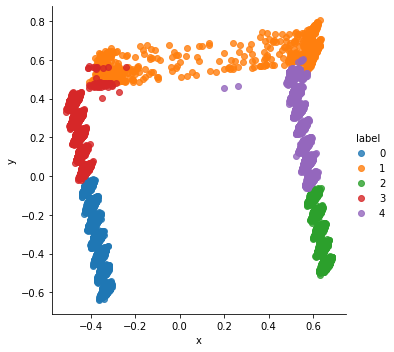

In [0]:
# visualize
# PCA
import seaborn as sns
from sklearn.decomposition import PCA

labels_kmeans = kmeans.predict(numeric_features_scaled)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_features_scaled)

# plotting clusters

pc = pd.DataFrame(principal_components)
pc['label'] = labels_kmeans
pc.columns = ['x', 'y','label']

cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)